In [14]:
# Imports
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', UserWarning)
import time
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.fft import fft
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.statespace.tools import diff
import pmdarima as pm
np.random.seed(0)                

In [15]:
def fft_analysis(signal):
    
    # Linear detrending
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1)
    trend = np.arange(len(signal)) * slope + intercept 
    detrended = signal - trend 
    
    fft_values = fft(detrended)
    frequencies = np.fft.fftfreq(len(fft_values))

    # Remove negative frequencies and sort
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0]

    # Identify dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)]
    print(f"Dominant Frequency: {dominant_frequency:.3f}")

    # Convert frequency to period (e.g., days, weeks, months, etc.)
    dominant_period = 1 / dominant_frequency
    print(f"Dominant Period: {dominant_period:.2f} time units")
    
    return dominant_period, positive_frequencies, magnitudes

def adftest(series, plots=True):
    out = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")
    
    if plots:
        # Compute rolling statistics
        rolmean = series.rolling(window=12).mean()
        rolstd = series.rolling(window=12).std()

        # Plot rolling statistics:
        plt.figure(figsize=(14, 4))
        plt.plot(series, color='tab:blue',label='Original')
        plt.plot(rolmean, color='tab:red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.grid(); 


In [16]:
co2 = pd.read_csv('https://zenodo.org/records/10951538/files/arima_co2.csv?download=1', 
                  header = 0,
                  names = ['idx', 'co2'],
                  skipfooter = 2)

# convert the column idx into a datetime object and set it as the index
co2['idx'] = pd.to_datetime(co2['idx'])
co2.set_index('idx', inplace=True)

# Rmove the name "idx" from the index column
co2.index.name = None


## Exercise

- Determine the presence of main trend and seasonality in the data.
- Determine if the data are stationary.
- Split the data in train (90%) and test (10%).
- Find a set of SARIMAX candidate models by looking at the ACF and PACF.
- Perform a grid search on the model candidates.
- Select the best models, based on performance metrics, model complexity, and normality of the residuals.
- Compare the best model you found with the one from autoarima.

### Points 1 + 2 + 3

- Run FFT analysis to identify seasonal component. Then, plot trend and seasonality using STL.
- Due to presence of trend and seasonality, the data is not stationary. Also ADF test is >> 0.



Dominant Frequency: 0.083
Dominant Period: 12.00 time units


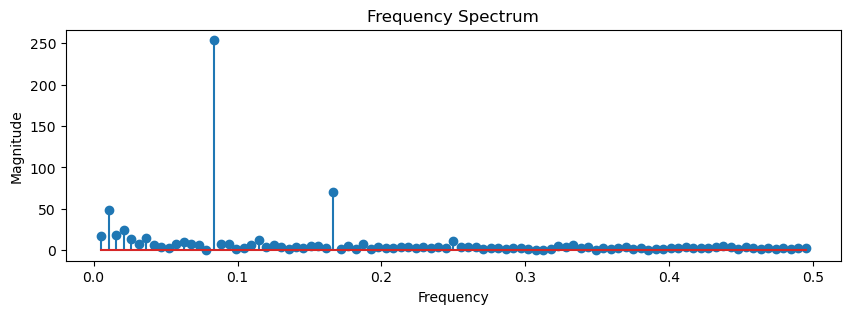

p-value: 0.9964336403294772


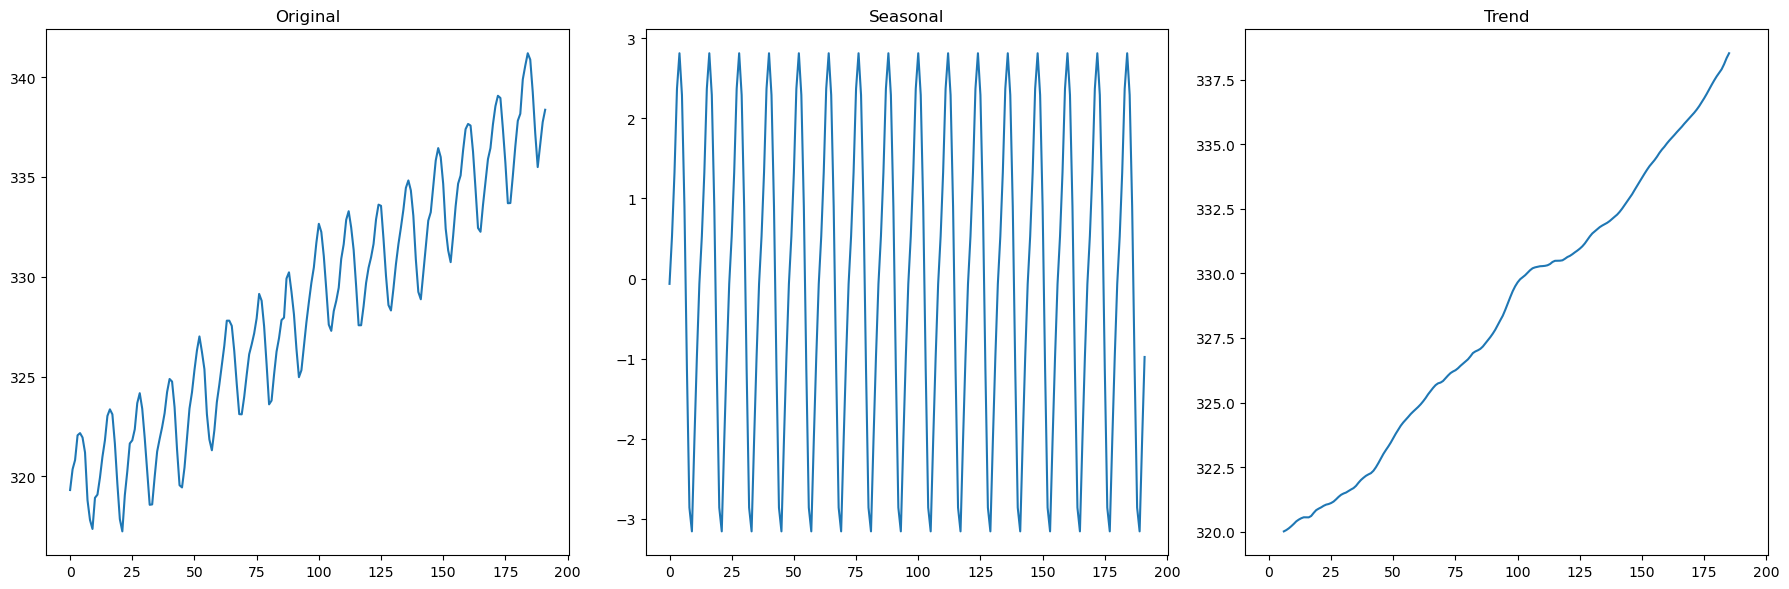

In [17]:
period, freqs, magnitudes = fft_analysis(co2['co2'].values)
# Plotting the spectrum
plt.figure(figsize=(10, 3))
plt.stem(freqs, magnitudes)
plt.title('Frequency Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

decomposition = seasonal_decompose(x=co2['co2'].values, model='additive', period=12)
seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, axs = plt.subplots(1,3, sharex=True, figsize=(18,6))
axs[0].plot(co2['co2'].values)
axs[0].set_title('Original')
axs[1].plot(seasonal)
axs[1].set_title('Seasonal')
axs[2].plot(trend)
axs[2].set_title('Trend')
plt.tight_layout()

# Perform the ADF test
_, pvalue, _, _, _, _ = adfuller(co2['co2'].values)
print(f'p-value: {pvalue}')


### POINT 4 + 5

- Train/test division in straightforeward.

SARIMAX MODELS

- Before finding parameter candidates for grid search, we already know that the seasonality has a period of 12.
- Note that the time series has both a trend and a seasonal component. It does not make sense to test values of differentiation of order zero, since differencing is always required to make the TS stationary.
- Le'ts apply first standard and then seasonal differencing to the data, tryng order 1 and 2.

In [18]:
def differencing(timeseries, s, D_max=2, d_max=2):
        
    # General differencing from 1 to d_max
    general_differenced = []
    for i in range(1, d_max+1):
        timeseries.name = f"d0_d{i}_s{s}"
        general_differenced.append(timeseries)
        timeseries = timeseries.diff()
    gen_df = pd.DataFrame(general_differenced).T

    # General differencing from 1 to D_max
    seas_differenced = []
    for j, ts in enumerate(general_differenced):
        for i in range(1,D_max+1):
            ts = ts.diff(periods=s)
            ts.name = f"D{i}_d{j}_s{s}"
            seas_differenced.append(ts)       
    seas_df = pd.DataFrame(seas_differenced).T
    
    # concatenate seasonal and general differencing dataframes
    return pd.concat([seas_df, gen_df], axis=1)

# create a summary of test results of all the series
def adf_summary(diff_series):
    summary = []
    
    for i in diff_series:
        # unpack the results
        a, b, c, d, e, f = adfuller(diff_series[i].dropna())
        g, h, i = e.values()
        results = [a, b, c, d, g, h, i]
        summary.append(results)
    
    columns = ["Test Statistic", "p-value", "#Lags Used", "No. of Obs. Used",
               "Critical Value (1%)", "Critical Value (5%)", "Critical Value (10%)"]
    index = diff_series.columns
    summary = pd.DataFrame(summary, index=index, columns=columns)
    
    return summary

In [19]:
# Splitting the data into training and testing sets
train_size = int(len(co2) * 0.9)
# Apply general and seasonal differencing to the series
train, test = co2['co2'].values[:train_size], co2['co2'].values[train_size:]
diff_series = differencing(co2['co2'], s=12, D_max=2, d_max=2)

# Check for stationarity using ADF test
adf_results = adf_summary(diff_series)
# filter away results that are not stationary
passed = adf_results[adf_results["p-value"] < 0.05]
# output indices as a list
index_list = pd.Index.tolist(passed.index)
# use the list as a condition to keep stationary time-series
passed_series = diff_series[index_list].sort_index(axis=1)
passed_series
# # Select the TS with the lowest ADF
# index_list = pd.Index.tolist(passed.index)
# best_series = diff_series[index_list].sort_index(axis=1).iloc[:,0].dropna()


,D1_d1_s12,D2_d0_s12,D2_d1_s12,d0_d2_s12
1965-01-01,NaN,NaN,NaN,NaN
1965-02-01,NaN,NaN,NaN,1.04
1965-03-01,NaN,NaN,NaN,0.46
1965-04-01,NaN,NaN,NaN,1.24
1965-05-01,NaN,NaN,NaN,0.11
...,...,...,...,...
1980-08-01,-0.36,0.16,-0.52,-2.06
1980-09-01,0.33,0.57,0.41,-1.70
1980-10-01,1.13,1.50,0.93,1.14
1980-11-01,-0.25,1.23,-0.27,1.11


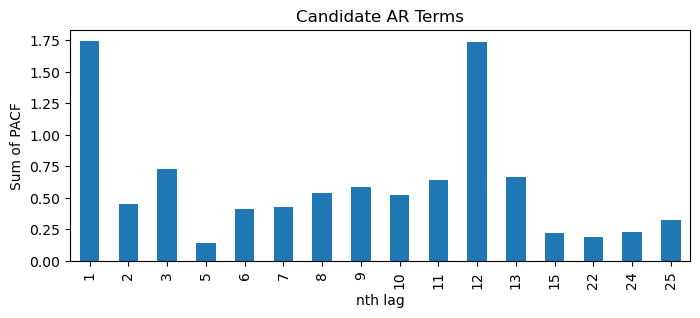

In [20]:
# FOR EACH TIME SERIES THAT IS STATIONARY, CREATE A SUMMARY PACF PLOT TO FIND THE BEST AR MODEL ORDER

df_sp_p = pd.DataFrame() 
for i in passed_series:
    # unpack the results into PACF and their CI
    PACF, PACF_ci = pacf(passed_series[i].dropna(), nlags=30, alpha=0.05, method='ywm')
    
    # subtract the upper and lower limits of CI by PACF to centre CI at zero
    PACF_ci_ll = PACF_ci[:,0] - PACF
    PACF_ci_ul = PACF_ci[:,1] - PACF
        
    # find positions of significant spikes representing possible value of p & P
    sp1 = np.where(PACF < PACF_ci_ll)[0]
    sp2 = np.where(PACF > PACF_ci_ul)[0]
        
    # PACF values of the significant spikes
    sp1_value = abs(PACF[PACF < PACF_ci_ll])
    sp2_value = PACF[PACF > PACF_ci_ul]
    
    # store values to dataframe
    sp1_series = pd.Series(sp1_value, index=sp1)
    sp2_series = pd.Series(sp2_value, index=sp2)
    df_sp_p = pd.concat((df_sp_p, sp1_series, sp2_series), axis=1)

# Sort the dataframe by index
df_sp_p = df_sp_p.sort_index()

# visualize sums of values of significant spikes in PACF plots ordered by lag
df_sp_p.iloc[1:].T.sum().plot(kind='bar', title='Candidate AR Terms', xlabel='nth lag', ylabel='Sum of PACF', figsize=(8,3));

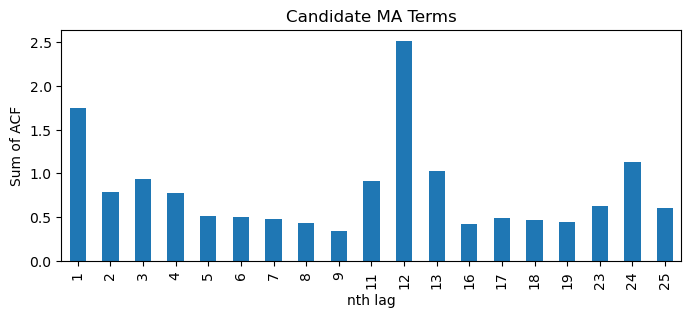

In [21]:
# DO THE SAME FOR ACF

df_sp_q = pd.DataFrame()
for i in passed_series:
    # unpack the results into ACF and their CI
    ACF, ACF_ci = acf(passed_series[i].dropna(), nlags = 30, alpha=0.05)
    
    # subtract the upper and lower limits of CI by ACF to centre CI at zero
    ACF_ci_ll = ACF_ci[:,0] - ACF
    ACF_ci_ul = ACF_ci[:,1] - ACF
    
    # find positions of significant spikes representing possible value of q & Q
    sp1 = np.where(ACF < ACF_ci_ll)[0]
    sp2 = np.where(ACF > ACF_ci_ul)[0]
    
    # ACF values of the significant spikes
    sp1_value = abs(ACF[ACF < ACF_ci_ll])
    sp2_value = ACF[ACF > ACF_ci_ul]
    
    # store values to dataframe
    sp1_series = pd.Series(sp1_value, index=sp1)
    sp2_series = pd.Series(sp2_value, index=sp2)
    df_sp_q = pd.concat((df_sp_q, sp1_series, sp2_series), axis=1)

# Sort the dataframe by index
df_sp_q = df_sp_q.sort_index()

# visualize sums of values of significant spikes in ACF plots ordered by lags
df_sp_q.iloc[1:].T.sum().plot(kind='bar', title='Candidate MA Terms', xlabel='nth lag', ylabel='Sum of ACF', figsize=(8,3));

To select p and P, lets look at the "cumulative" PACF:
- The PACF shows relevant spikes at lags 1/2/3. The grid search for p Will be {1,2,3}
- To identify P, lets look at spikes at multiples of seasonal component: lag 12 presents a big spike in the PACF, lag 24 does not, P = {0, 1}

To select q and Q lets look at the "cumulative" ACF:
- The ACF shows relevant spikes at lags 1/2/3. The grid search for q Will be {1,2,3}
- Seasonal spikes are present both at lag 12 and 24 (multiples of seasonal period). Q = {0, 1, 2}.

The values od D and d will be {1, 2} from previous analysis.



In [22]:
# possible values
p = [1, 2, 3]
d = [1, 2]
q = [1, 2, 3]
P = [0, 1]
D = [0, 1, 2]
Q = [1, 2]
s = [12]

# create all combinations of possible values
pdq = list(product(p, d, q))
PDQm = list(product(P, D, Q, s))

warnings.simplefilter("ignore")
def SARIMA_grid(endog, order, seasonal_order):

    # create an empty list to store values
    model_info = []
       
    #fit the model
    for i in order:
        for j in seasonal_order:
            try:
                model_fit = SARIMAX(endog=endog, order=i, seasonal_order=j).fit(disp=False)
                predict = model_fit.predict()
            
                # calculate evaluation metrics: MAPE, RMSE, AIC & BIC
                MAPE = (abs((endog-predict)[1:])/(endog[1:])).mean()
                MSE = mse(endog[1:], predict[1:])
                AIC = model_fit.aic
                BIC = model_fit.bic
            
                # save order, seasonal order & evaluation metrics
                model_info.append([i, j, MAPE, MSE, AIC, BIC])
            except:
                continue
                
    # create a dataframe to store info of all models
    columns = ["order", "seasonal_order", "MAPE", "MSE", "AIC", "BIC"]
    model_info = pd.DataFrame(data=model_info, columns=columns)
    return model_info

### POINT 6

Lets test our models using different metrics:

- Performance: MSE/MAPE to evaluate absolute and relative error of the model.
- Complexity: AIC/BIC. That said, all models tested are generally light. I would prioritize performances metrics.
- Normality of the residuals: Since the train size is only 172 samples, automatic methods such as Jaque-Brera are not fully reliable. For this reason, I would select the two best models for MSE and BIC and check histogram plot of residuals.

In [23]:
start = time.time()
# fit all combinations into the model
model_info = SARIMA_grid(endog=train, order=pdq, seasonal_order=PDQm)

end = time.time()
print(f'time required: {end - start :.2f}')



time required: 950.07


In [24]:
print("Least MAPE")
least_MAPE = model_info.nsmallest(3, "MAPE")
print(least_MAPE)
least_MSE = model_info.nsmallest(3, "MSE")
print("Least MSE")
print(least_MSE)
least_AIC = model_info.nsmallest(3, "AIC")
print("Least AIC")
print(least_AIC)
least_BIC = model_info.nsmallest(3, "BIC")
print("Least BIC")
print(least_BIC)


Least MAPE
        order seasonal_order      MAPE       MSE         AIC         BIC
30  (1, 1, 3)  (1, 0, 1, 12)  0.000931  0.174218  135.086397  157.078042
91  (2, 1, 2)  (1, 0, 2, 12)  0.000936  0.177174  137.385507  162.518815
90  (2, 1, 2)  (1, 0, 1, 12)  0.000937  0.177353  135.365444  157.357089
Least MSE
        order seasonal_order      MAPE       MSE         AIC         BIC
31  (1, 1, 3)  (1, 0, 2, 12)  0.000937  0.173008  139.888718  165.022027
30  (1, 1, 3)  (1, 0, 1, 12)  0.000931  0.174218  135.086397  157.078042
91  (2, 1, 2)  (1, 0, 2, 12)  0.000936  0.177174  137.385507  162.518815
Least AIC
         order seasonal_order      MAPE           MSE        AIC         BIC
209  (3, 2, 3)  (1, 0, 2, 12)  0.277381  12265.701475  28.098804   59.456788
2    (1, 1, 1)  (0, 1, 1, 12)  0.003808    147.660729  91.093198  103.368815
74   (2, 1, 1)  (0, 1, 1, 12)  0.003806    147.660250  91.827088  107.171609
Least BIC
         order seasonal_order      MAPE           MSE        AIC   

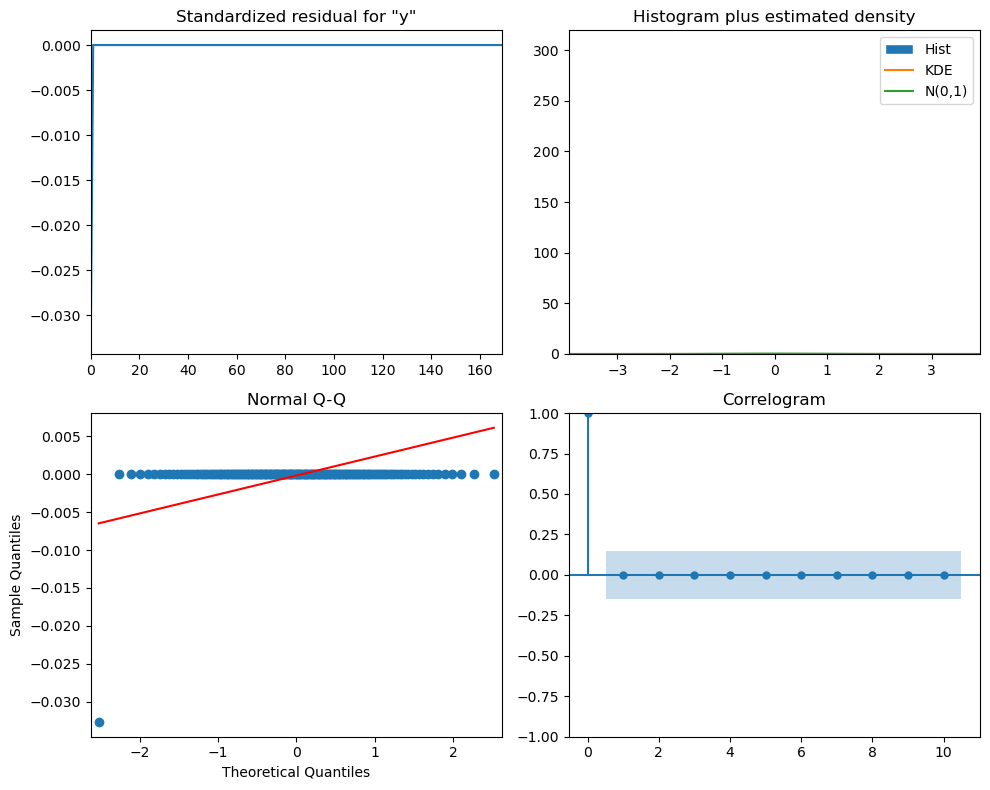

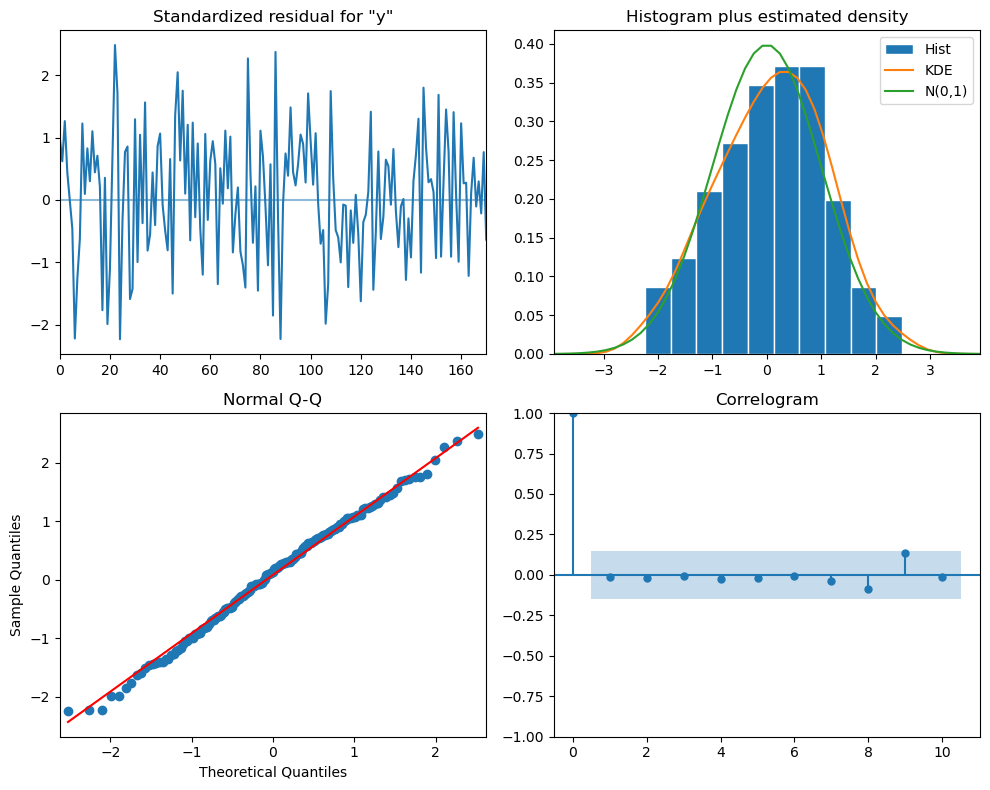

In [25]:
best_BIC_params = model_info.nsmallest(1, "BIC").iloc[0]
best_MSE_params = model_info.nsmallest(1, "MSE").iloc[0]


best_BIC_model = SARIMAX(endog=train, order=best_BIC_params.order, seasonal_order=best_BIC_params.seasonal_order).fit(disp=False)
best_MSE_model = SARIMAX(endog=train, order=best_MSE_params.order, seasonal_order=best_MSE_params.seasonal_order).fit(disp=False)


BIC_resid = best_BIC_model.resid
MSE_resid = best_MSE_model.resid

best_BIC_model.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()

best_MSE_model.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()

The residual best models considering BIC and MSE are both normal enaugh. In this case, I would select as best overall model the one with lowset MSE, since the best BIC model have a
The best BIC model has a huge MSE value (147.7, that is 100x higher than the best MSE model)
On the other hand, the best MSE model has a relatively low BIC valew when compared to the best BIC model (158, that is 1.5x higher than best BIC model)

For this reason I would select the model with lowest MSE as the go-to model.

### POINT 7

Let us run auto arima using the same parameters used for grid search:

In [28]:
# Use auto_arima to find the best ARIMA model
# Don't set manually the differentiation order, let autoarima pick one.
autoarima_model = pm.auto_arima(train, 
                      start_p=1, start_q=1,
                      test='adf',       # Use adftest to find optimal 'd'
                      max_p=3, max_q=3, # Maximum p and q
                      m=12,             # Seasonality
                      start_P=0, start_Q=0,
                      max_P=1, max_Q=2, # Maximum p and q
                      seasonal=True,    # Seasonal ARIMA
                      d=True,           
                      trace=True,       # Print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # Stepwise search to find the best model

# Summarize the model
print(autoarima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,True,1)(0,1,0)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,True,0)(0,1,0)[12]             : AIC=170.140, Time=0.01 sec
 ARIMA(1,True,0)(1,1,0)[12]             : AIC=116.893, Time=0.08 sec
 ARIMA(0,True,1)(0,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(1,True,0)(0,1,0)[12]             : AIC=167.257, Time=0.02 sec
 ARIMA(1,True,0)(1,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(1,True,0)(0,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(0,True,0)(1,1,0)[12]             : AIC=119.563, Time=0.05 sec
 ARIMA(2,True,0)(1,1,0)[12]             : AIC=118.806, Time=0.11 sec
 ARIMA(1,True,1)(1,1,0)[12]             : AIC=116.214, Time=0.19 sec
 ARIMA(1,True,1)(1,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(1,True,1)(0,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(0,True,1)(1,1,0)[12]             : AIC=116.499, Time=0.07 sec
 ARIMA(2,True,1)(1,1,0)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(1,True,2)(1,

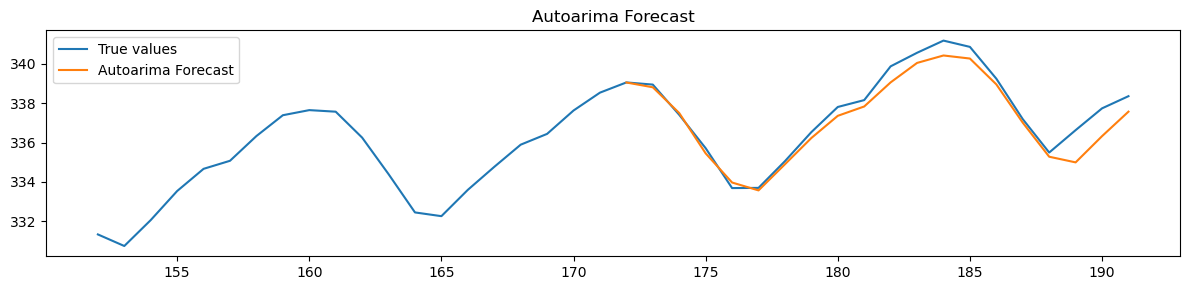

AUTOARIMA MSE: 0.40


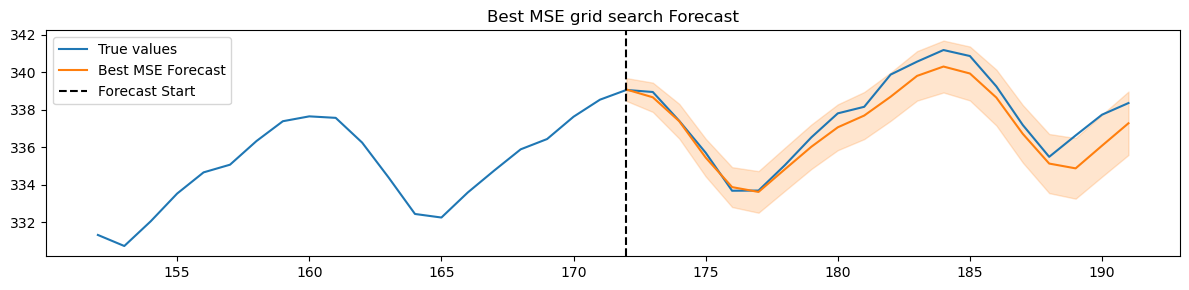

SARIMAX MSE: 0.63


In [40]:
# FORECASTING WITH AUTOARIMA
autoarima_forecast = autoarima_model.predict(n_periods=len(test)) 
total_size = len(co2['co2'].values)
test_size = len(test)

x1 = np.arange(train_size - 20, total_size)
x2 = np.arange(total_size- test_size, total_size)

plt.figure(figsize=(12, 3))
plt.plot(x1, co2['co2'].values[train_size-20:], label='True values', color='tab:blue')
plt.plot(x2, autoarima_forecast, label='Autoarima Forecast', color='tab:orange')
plt.title('Autoarima Forecast')
plt.tight_layout()
plt.legend()
plt.show()
# Calculate MSE for the autoarima forecast
print(f"AUTOARIMA MSE: {mse(test,autoarima_forecast):.2f}")

# Forecasting with the best MSE model
best_MSE_forecast = best_MSE_model.get_prediction(train_size, len(co2['co2'].values)-1).summary_frame() # Compute preds

x2 = np.arange(total_size- test_size, total_size)
plt.figure(figsize=(12, 3))
plt.plot(x1, co2['co2'].values[train_size-20:], label='True values', color='tab:blue')
plt.plot(x2, best_MSE_forecast['mean'], label='Best MSE Forecast', color='tab:orange')
plt.fill_between(x2, best_MSE_forecast['mean_ci_lower'], best_MSE_forecast['mean_ci_upper'], color='tab:orange', alpha=0.2)
plt.axvline(x=train_size, color='black', linestyle='--', label='Forecast Start')
plt.title('Best MSE grid search Forecast')
plt.tight_layout()
plt.legend()
plt.show()

print(f"SARIMAX MSE: {mse(test,best_MSE_forecast['mean']):.2f}")